In [1]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm
import copy
import seaborn as sns

import sys
sys.path.append("../code_on_slurm")
from utils import *
from lag_test_utils import *
from scipy.optimize import root_scalar

import matplotlib as mpl
import pandas as pd
# Set the default font and size
plt.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12

In [2]:
import pickle

# load the data for diversity vs frac_seq
pool_size=100
n_rho = 40
fracs = []
divs = []
rholist = np.linspace(1e-4, 0.4, n_rho)
for rho in rholist:
    data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
    fracs_phi = []
    for i in data:
        # get the fraction of biomass of the sequential species
        ids = i[0][1]["ids"]
        bs = i[0][1]["bs"][-1]
        fracs_phi.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
    fracs.append(np.mean(fracs_phi))
    divs.append(np.mean([len(i[0][1]["ids"]) for i in data]))

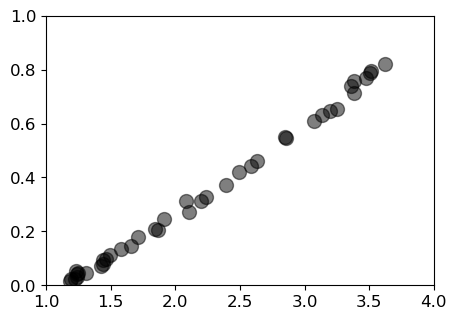

In [3]:
plt.figure(figsize=(5, 3.5))
plt.scatter([np.mean(i) for i in divs], fracs, color='k', alpha=0.5, s=100)
plt.xlim(1.0, 4.0)
plt.ylim(0, 1.0)
plt.savefig("fig3-1.pdf", bbox_inches="tight")

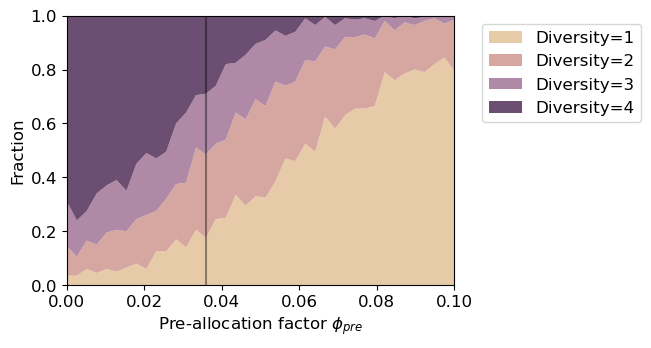

In [4]:
import pickle

pool_size = 100
n_rho=40

# head-to-head
# pool_size=2
# divs = []
# rholist = np.linspace(1e-4, 0.4, n_rho)
# for rho in rholist:
#     data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
#     div = [0, 0]
#     for i in data:
#         div[min(4, len(i[0][1]["ids"]))-1]+=1
#     divs.append(div)
# divs = np.array(divs)
# divs = divs/divs.sum(axis=1, keepdims=True)


# in community
pool_size = 100
divs = []
rholist = np.linspace(1e-4, 0.4, n_rho)
for rho in rholist:
    data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
    div = [0, 0, 0, 0]
    for i in data:
        div[min(4, len(i[0][1]["ids"]))-1]+=1
    divs.append(div)
divs_100 = np.array(divs)
divs = np.array(divs)
divs = divs/divs.sum(axis=1, keepdims=True)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create the main plot
fig, ax = plt.subplots(figsize=(5, 3.5))
bottom = np.zeros(len(divs)) 
# Plot each category's relative abundance
colors = ['#6B4E71', '#B089A6', '#D6A7A1', '#E7CBA9'][::-1]
ax.stackplot(rholist/4, divs.T, colors=colors, labels=[f'Diversity={i+1}' for i in range(divs.shape[1])])

# divs_2 = divs / data.sum(axis=1, keepdims=True)
# ax.plot(rholist/4, fracs_2, markerfacecolor='none', color="k", marker='o', markersize=7)
# ax.plot(rholist/4, fracs_100, markerfacecolor='none', color="#00CD6C", marker='o', markersize=7)
ax.set_xlabel("Pre-allocation factor $\\phi_{pre}$")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
# ax.set_ylabel("Fraction of sequential species\n(by #(species))")
# ax.axhline(1.0, color="k", alpha=0.4)
ax.set_ylim(0, 1)
ax.set_xlim(0, 0.1)
ax.set_ylabel("Fraction")
ax.axvline(rholist[14]/4, color="k", alpha=0.4)
plt.savefig("fig3-2.pdf", bbox_inches="tight")
# plt.show()

0.45962366622652856 14 0.03591346153846154
0.0


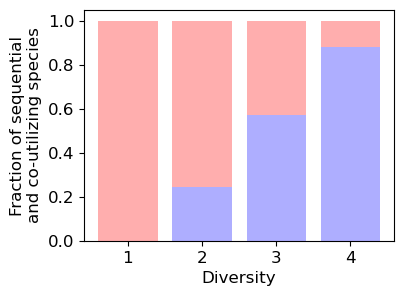

In [38]:
# look at stratification of a datapoint
pool_size=100
n_rho = 40
stratified = []
rholist = np.linspace(1e-4, 0.4, n_rho)
for rho in rholist:
    data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
    stratified.append([0.5, 0.5, 0.5, 0.5])
    for div in np.arange(1, 5):
        fracs_ = []
        for i in data:
            ids = i[0][1]["ids"]
            bs = i[0][1]["bs"][-1]
            if(len(ids)==div):
                fracs_.append(np.sum([bs[idx] for idx, j in enumerate(ids) if j<pool_size/2]) / np.sum(bs))
        if(len(fracs_)>0):
            stratified[-1][div-1] = np.mean(fracs_)
for i in range(n_rho):
    if(abs(fracs[i]-0.5)<0.045):
        print(fracs[i], i, rholist[i]/4)
        plt.figure(figsize=(4, 3))
        plt.bar(np.arange(1, 5), [1, 1, 1, 1], color="#ffaeae")
        plt.bar(np.arange(1, 5), stratified[i], color = "#aeaeff")
        print(stratified[i][0])
        plt.xticks(np.arange(1, 5))
        # plt.axhline(frac_diaux[i], color='k')
        plt.xlabel("Diversity")
        plt.ylabel("Fraction of sequential\nand co-utilizing species")
plt.savefig("fig3-3.pdf", bbox_inches="tight")

In [2]:
# structural stability 
def G_mat_hwa(spc_list, dep_order):
    '''
    spc: species obbject list of length N=R
    dep_order: array([R])
    '''
    R = len(dep_order)
    N = R
    G = np.zeros([N, R])
    for i_n, spc in enumerate(spc_list):
        for i_t in range(R):
            Rs = np.array([1*(res+1 in dep_order[i_t:]) for res in range(R)])
            spc.lag_left=0
            spc.GetEating(Rs)
            G[i_n, i_t] = spc.GetGrowthRate()            
    return G

def NicheGrowthState(spcs, dep_order, t_order):
    '''
    spcs: list of species (object; SeqUt_alt or CoUt_alt) 
    dep_order: np array; order of resources (1 to R) depleted
    t_order: np array; time spans of each temporal niche. 
    '''
    # RE: resource_eating for [spc, niche], 
    # in an np array with boolean list of elements
    N, R = len(spcs), len(dep_order)
    RE = np.zeros([N, R], dtype=object)
    for i_n in range(N):
        for i_t in range(R):
            Rs = np.zeros(R)
            for res in dep_order[i_t:]:
                Rs[res-1] = 1
            spcs[i_n].lag_left = 0
            spcs[i_n].GetEating(Rs)
            RE[i_n, i_t] = spcs[i_n].eating
    # here we define a niche growth state matrix S, whose elements can be 0, 1, or 2
    # 0 means no growth; 1 means growth during full niche; 2 means part of of niche is taken by lag
    # and define a tau_mod - the lag time in each niche for those 2 elements in S. 
    # initialize by all niche - all growth
    S = np.ones([N, R])
    tau_mod = np.zeros([N, R])
    for i_n, spc in enumerate(spcs):
        in_lagphase = 0
        tau_new = 0
        for niche in np.arange(0, R):
            # if next time niche is a different resource, 
            # we assume the species would renew the current lag by the lagtime of
            # switching from the previous (actively consuming) nutrient to the current nutrient
            # regardless of whether it was already in the middle of a lag phase or not. 
            if(niche==0 or not np.array_equal(RE[i_n, niche], RE[i_n, niche-1])):
                # update the lag
                if(niche==0):
                    tau_new = spc.tau_init
                else:
                    Rs = np.array([int(i+1 in dep_order[niche:]) for i in range(R)]) # if res is in leftover resources then 1; else 0
                    tau_new = spc.tau_f(Rs, spc.rho, spc.tau0)
                # check if this lag outlasts the t-niche
                if(tau_new < t_order[niche]):
                    S[i_n, niche] = 2
                    tau_mod[i_n, niche] = tau_new
                    in_lagphase = 0
                else:
                    S[i_n, niche] = 0
                    tau_new -= max(0, t_order[niche])
                    in_lagphase = 1
            # if the next time niche is a same resource, 
            # when the species has not yet finished a lag, it would continue being in that lag
            # with no need to renew the lagtime value. 
            elif(in_lagphase == 1):
                if(tau_new < t_order[niche]):
                    S[i_n, niche] = 2
                    tau_mod[i_n, niche] = tau_new
                    in_lagphase = 0
                else:
                    S[i_n, niche] = 0
                    tau_new -= max(0, t_order[niche])
            # else: the spc was growing and the next niche it's eating the same stuff. S=1 and tau_mod=0. 
    return S, tau_mod

def TsolveIter(spc_list, dep_order, logD, T=24): # N = R must be ensured
    # species-niche growth state S
    N = len(spc_list)
    R = N
    S = np.ones([N, R]) * 2 # initialize S at 2. 0 is all lag in this niche and 1 is all growth
    # before the first iter
    converged = 0
    t_iter_compare = np.zeros(R)
    G = G_mat_hwa(spc_list, dep_order)
    # for the first iteration of S and tau_mod, go with all t_order=max
    S, tau_mod = NicheGrowthState(spc_list, dep_order, np.ones(R)*T)
    # to keep time short do 10 iters at most
    for count in range(10): 
        # rhs: [Gt = logD]'s rhs, vec of len R
        rhs = logD + np.diag( (G*(S>0)) @ np.transpose(tau_mod) )
        if(np.linalg.matrix_rank(G*(S>0))>=N):
            t_iter = np.linalg.inv(G*(S>0))@rhs
            # update S and tau_mod based on this set of new t_iter
            S, tau_mod = NicheGrowthState(spc_list, dep_order, t_iter)
            if ((t_iter_compare==t_iter).all() and np.sum(t_iter)<=24):
                converged = 1
                break
            t_iter_compare = t_iter
        else:
            converged = 0
            break
    return converged, t_iter_compare, S, tau_mod

def FMatLag(spcs, dep_order, t_order, S, tau_mod):
    N, R = len(spcs), len(dep_order)
    F_mat = np.zeros([N, R])
    for i_n in range(N):
        coeff = 1
        for i_t in range(R):
            Rs = np.zeros(R)
            for res in dep_order[i_t:]:
                Rs[res-1] = 1
            spcs[i_n].GetEating(Rs)
            g = spcs[i_n].GetGrowthRate()
            vec_dep = spcs[i_n].GetDep()
            if(S[i_n, i_t] == 1):
                dep = coeff * (exp(g*t_order[i_t]) - 1)
                coeff *= exp(g*t_order[i_t])
            elif S[i_n, i_t] == 2:
                dep = coeff * (exp(g*(t_order[i_t]-tau_mod[i_n, i_t])) - 1)
                coeff *= exp(g*(t_order[i_t]-tau_mod[i_n, i_t]))
            else:
                dep=0
            F_mat[i_n, :] += dep * vec_dep
    return np.transpose(F_mat)

In [4]:
# If the algorithm is basically fine
# generate a lot of communities
# check their feasibility and stability
# for sequential communities:
R = 4
n_rho = 40
rholist = np.linspace(1e-4, 0.4, n_rho)
rho = rholist[14]
N_community = 10000
gmean, gsigma, gC, R, D, T_dilute = 0.5, 0.1, 1.0, 4, 1000, 24

all_stabilities = []
for Nseq in [0, 1, 2, 3, 4]:
    Ncout = 4-Nseq
    stabilities = []
    for i in tqdm(range(N_community)):
        g_seq = generate_g(Nseq, R, gmean, gsigma)
        g_cout = generate_g(Ncout, R, gmean, gsigma)
        permutations = list(itertools.permutations(list(range(1, R+1))))
        pref_list = np.array(random.choices(permutations, k=Nseq))
        col = np.argmax(g_seq, axis=1) # find column in g where it's the largest
        for row_i, row in enumerate(pref_list):
            index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
            row[0], row[index] = row[index], row[0]
        species_list = []
        for i in range(Nseq):
            species_list.append(SeqUt_alt(rho=rho, g_enz=g_seq[i], gC=gC, pref_list=pref_list[i], biomass=0.01, id=i))
        for i in np.arange(Nseq, Nseq+Ncout):
            species_list.append(CoUt_alt(rho=rho, g_enz=g_cout[i-Nseq], gC=gC, biomass=0.01, id=i))
        tau_init_dist = lambda x: np.random.uniform(2, 3)
        tau_0_dist = lambda x: np.random.uniform(0.2, 0.4)
        for species in species_list:
            tau0 = tau_0_dist(0)
            tau_init = tau_init_dist(0)
            if(species.cat=="Seq"):
                species.SetLag(tau0, TaufSeq, tau_init)
                species.b = 0.01
            else:
                species.SetLag(tau0, TaufCout, tau_init)
                species.b = 0.01
            species.RezeroLag()
        
        dep_orders = np.array(permutations)
        N_dep_order = len(dep_orders)
    
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            G = G_mat_hwa(species_list, dep_order)
            if(np.linalg.matrix_rank(G)>=Nseq+Ncout):
                converged, t_iter, S, tau_mod = TsolveIter(species_list, dep_order, logD=np.log(D), T=24)
                if(converged == 1 and sum(t_iter>0) >= len(t_iter)):
                    F = FMatLag(species_list, dep_order, t_iter, S, tau_mod)
                    if(abs(np.linalg.det(F))>1e-10):
                        stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(log(D))-1)**R)/log(10))/(R-1) )
    all_stabilities.append(stabilities)
pickle.dump(all_stabilities, open("../data/stabilities/stability_dist_main.pkl", "wb"))

100%|██████████| 10000/10000 [04:33<00:00, 36.59it/s]


In [3]:
all_stabilities = pickle.load(open("../data/stabilities/stability_dist_main.pkl", "rb"))

In [4]:
def generate_intermediate_colors(hex_color1, hex_color2, num_colors):
    # Convert hex codes to RGB format
    color1_rgb = tuple(int(hex_color1[i:i+2], 16) for i in (1, 3, 5))
    color2_rgb = tuple(int(hex_color2[i:i+2], 16) for i in (1, 3, 5))
    
    # Calculate the step size for each color component
    step_r = (color2_rgb[0] - color1_rgb[0]) / (num_colors + 1)
    step_g = (color2_rgb[1] - color1_rgb[1]) / (num_colors + 1)
    step_b = (color2_rgb[2] - color1_rgb[2]) / (num_colors + 1)
    
    # Generate intermediate colors
    intermediate_colors = [hex_color1]
    for i in range(1, num_colors + 1):
        r = int(color1_rgb[0] + step_r * i)
        g = int(color1_rgb[1] + step_g * i)
        b = int(color1_rgb[2] + step_b * i)
        intermediate_colors.append('#{:02x}{:02x}{:02x}'.format(r, g, b))
    intermediate_colors.append(hex_color2)
    
    return intermediate_colors

/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


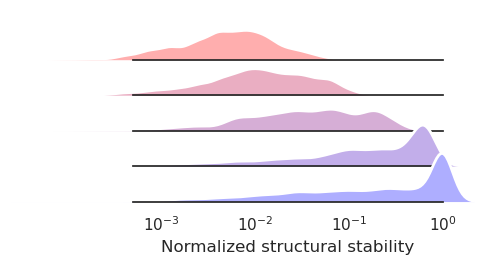

In [5]:
import seaborn as sns

n_cut = min([len(i) for i in all_stabilities])
plt.rcParams["figure.figsize"] = (6, 4)
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
colors = generate_intermediate_colors("#ffaeae", "#aeaeff", 3)
palette = sns.color_palette(colors, 5)
data = {"n_diaux":sum([[i for j in stabilities] for i, stabilities in enumerate(all_stabilities)], []), 
        "stability":sum([i for i in all_stabilities], [])}
data = pd.DataFrame(dict(n_diaux=data["n_diaux"], stability=data["stability"]))
grid = sns.FacetGrid(data, row="n_diaux", hue="n_diaux", aspect=8, height=0.5, palette=palette)
grid.map(sns.kdeplot, "stability", bw_adjust=.6, clip_on=False, fill=True, lw=0, alpha=1)
grid.map(sns.kdeplot, "stability", clip_on=False, color="w", lw=2, bw_adjust=.6)
grid.figure.subplots_adjust(hspace=-.3)
grid.set_titles("")
grid.set(yticks=[], ylabel="")
grid.despine(left=True)
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, ha="left", va="center", transform=ax.transAxes)
#     ax.text(1, .2, R-int(label), ha="right", va="center", transform=ax.transAxes)
# grid.map(label, "n_diaux")
plt.xticks(np.arange(0, -4, -1), ["10$^{"+str(i)+"}$" for i in np.arange(0, -4, -1)])
plt.xlim(-3.3, 0)
plt.xlabel("Normalized structural stability")
plt.savefig("fig3-4.pdf", bbox_inches="tight")
# plt.savefig("../figures/struc_stability_ridges.pdf", bbox_inches="tight")
# plt.show()